In [1]:
import pdb
from math import log10, floor

import numpy as np
import scipy.optimize as op
import scipy
import scipy.special as spec
from scipy import stats
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import corner

import astropy
from astropy import stats as astrostats
from astropy.timeseries import LombScargle

import emcee
import radvel

from analysis_scripts import sval_correlations

%matplotlib inline

## Simulate activity alias.

In [7]:
def one_epoch(offset=0):
    return 365*offset + np.random.uniform(high=187.625, size=50)

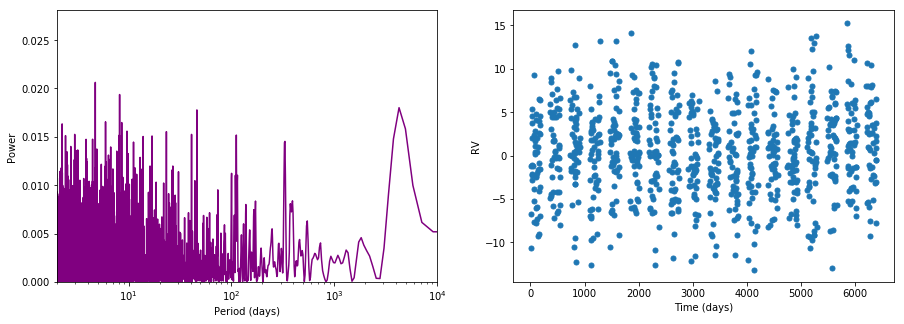

In [8]:
times = np.concatenate((one_epoch(0), one_epoch(1), one_epoch(2),
                        one_epoch(3), one_epoch(4), one_epoch(5), 
                        one_epoch(6), one_epoch(7), one_epoch(8), 
                        one_epoch(9), one_epoch(10), one_epoch(11), 
                        one_epoch(12), one_epoch(13), one_epoch(14), 
                        one_epoch(15), one_epoch(16), one_epoch(17)
                      ))
rvs = np.sin(2*np.pi*times/5000.) + 5*np.random.randn(len(times))
frequency, power = LombScargle(times, rvs).autopower(nyquist_factor=100)

#fig, ax = plt.subplots()
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(1/frequency, power, c='purple')
#ax.axvline(1/frequency[np.argmax(power)], ls='--', 
#           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
axes[0].set_xscale('log')
axes[0].set_xlim([2, 10**4])
axes[0].set_ylim([0, 1.1*np.amax(power)])
axes[0].set_xlabel('Period (days)')
axes[0].set_ylabel('Power')

axes[1].scatter(times, rvs)
axes[1].set_xlabel('Time (days)')
axes[1].set_ylabel('RV')

fig.savefig('plots/activity_alias_sim.png', dip=200)

## Do the same but with Gaussian process samples.

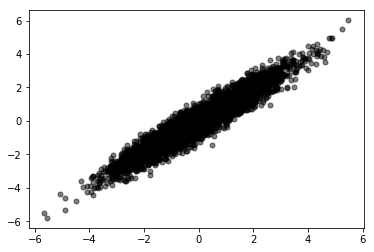

In [5]:
mean = [0, 0]
cov = [[2.1, 2], [2, 2.1]] 
#mean = [0, 0, 0]
#cov = [[2, 0.8, 3], [2, 1, 5], [5, 0, 0]] 
#x = np.arange(5000)
x, y = np.random.multivariate_normal(mean, cov, 5000).T


fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.5, c='black')
#plt.axis('equal')

In [2]:
def square_exp(xa, xb, l=800, sigma=0.1):
    """Exponentiated quadratic with L2 distance (Squared Euclidian)"""
    norm = -scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')/(2*l**2)
    return np.exp(norm) + np.identity(len(xa))*sigma**2

def periodic(xa, xb, A=1, G=1, P=0, sigma=0.1):
    norm = -G**2 * np.sin(np.pi*scipy.spatial.distance.cdist(xa, xb, 'cityblock')/P)**2
    return A*np.exp(norm) + np.identity(len(xa))*sigma**2

def quasiper(xa, xb, A=1, l=800, G=1, P=1000, sigma=0.001):
    snorm = -scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')/(2*l**2)
    pnorm = -G**2 * np.sin(np.pi*scipy.spatial.distance.cdist(xa, xb, 'cityblock')/P)**2
    return A*np.exp(snorm + pnorm) + np.identity(len(xa))*sigma**2


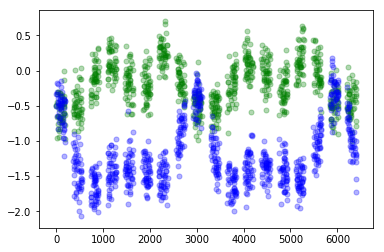

In [16]:
X = np.expand_dims(times, 1) # Independent variable samples
Cov = quasiper(X, X, l=10**5, G=1, P=3000, sigma=0.2)  # Kernel of data points
number_of_functions = 5 # Number of GPs to sample

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
draws = np.random.multivariate_normal(
        mean=np.zeros(len(times)), cov=Cov, 
        size=number_of_functions)

fig, ax = plt.subplots()
ax.scatter(times, draws[0], color='green', alpha=0.3)
ax.scatter(times, draws[1], color='blue', alpha=0.3)
#ax.scatter(times, draws[2], color='red', alpha=0.3)
#ax.scatter(times, draws[3], color='purpl3', alpha=0.3)
#ax.scatter(times, draws[4], color='black', alpha=0.3)

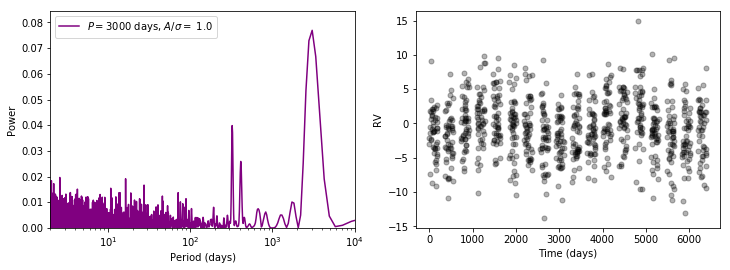

In [29]:
P = 3000
A = 4
sigma = 4

X = np.expand_dims(times, 1) # Independent variable samples
Cov = periodic(X, X, A=A, sigma=sigma, G=1, P=P)  
number_of_functions = 5 # Number of GPs to sample

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
draws = np.random.multivariate_normal(
        mean=np.zeros(len(times)), cov=Cov, 
        size=number_of_functions)

# Make periodogram, plot alongside simulated data.
rvs = draws[0]
frequency, power = LombScargle(times, rvs).autopower(nyquist_factor=100)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(1/frequency, power, c='purple', label=r'$P = {}$ days, $A/\sigma = $ {}'.format(P, A/sigma))

axes[0].set_xscale('log')
axes[0].set_xlim([2, 10**4]) 
axes[0].set_ylim([0, 1.1*np.amax(power)])
axes[0].set_xlabel('Period (days)')
axes[0].set_ylabel('Power')
axes[0].legend()

axes[1].scatter(times, rvs, color='black', alpha=0.3)
axes[1].set_xlabel('Time (days)')
axes[1].set_ylabel('RV')

fig.savefig('plots/activity_alias_qper.png', dip=200)

## Load entirety of Legacy catalog dataset.

In [30]:
data_all = pd.read_csv('../rvdata/legacy_all_data.csv')

In [31]:
data_all.psf3

0         0.007310
1         0.008032
2         0.004509
3         0.006225
4         0.010519
            ...   
104715    0.135589
104716    0.112562
104717    0.202131
104718    0.096453
104719    0.117888
Name: psf3, Length: 104720, dtype: float64

In [3]:
data_all.query('tel == "j"').sval

18        0.1620
19        0.1630
20        0.1620
21        0.1620
22        0.1630
           ...  
103986    0.1450
103987    0.1450
103988    0.1487
103989    0.1454
103990       NaN
Name: sval, Length: 48712, dtype: float64

## Query for data associated with star of interest, in this case 177830.

In [10]:
data_ours = data_all.query('name == "177830"').reset_index()

In [11]:
data_ours.bc

0        784.911987
1        648.963989
2      11966.449219
3      -7495.011230
4       8565.545898
           ...     
275   -18550.306641
276   -18767.542969
277   -19732.539062
278   -19786.996094
279   -19901.263672
Name: bc, Length: 280, dtype: float64

### Load two-planet model.

In [12]:
post = radvel.posterior.load('../rvdata/177830/post_final.pkl')

In [13]:
data_hires = data_ours.query('tel == "j" or tel == "k"').reset_index()
data_apf   = data_ours.query('tel == "apf"').reset_index()

In [17]:
rvs_to_play_hires = np.array(data_hires.mnvel)
rvs_to_play_apf   = np.array(data_apf.mnvel)
psf1_hires        = np.array(data_hires.psf1)
psf2_hires        = np.array(data_hires.psf2)
psf3_hires        = np.array(data_hires.psf3)
bcs_hires         = np.array(data_hires.bc)
bcs_apf           = np.array(data_apf.bc)
svals_apf         = np.array(data_apf.sval)

In [18]:
orbel = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]
mod_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel)
mod_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel)
rvs_to_play_hires -= mod_hires
rvs_to_play_apf   -= mod_apf

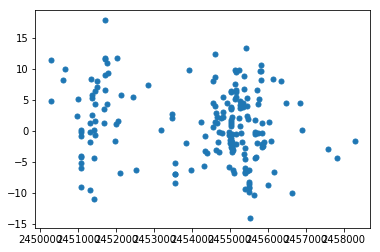

In [16]:
fig, ax = plt.subplots()
ax.scatter(data_hires.jd, rvs_to_play_hires)

Text(0, 0.5, 'RV (m/s)')

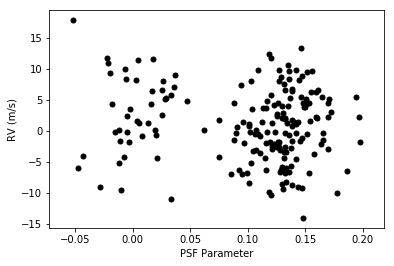

In [25]:
fig, ax = plt.subplots()
ax.scatter(psf3_hires, rvs_to_play_hires, c='black')
ax.set_xlabel('PSF Parameter')
ax.set_ylabel('RV (m/s)')
#ax.set_xlim([-0.03, 0.02])

Text(0, 0.5, 'RV (m/s)')

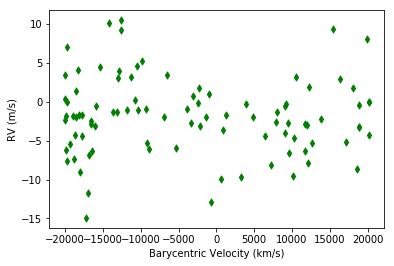

In [48]:
fig, ax = plt.subplots()
ax.scatter(bcs_apf, rvs_to_play_apf, c='green', marker='d')
ax.set_xlabel('Barycentric Velocity (km/s)')
ax.set_ylabel('RV (m/s)')

## Do the same for 168009.

In [5]:
data_ours = data.query('name == "168009"').reset_index()
post = radvel.posterior.load('../rvdata/168009/post_final.pkl')

In [6]:
data_hires = data_ours.query('tel == "j"').reset_index()
data_apf   = data_ours.query('tel == "apf"').reset_index()

In [7]:
rvs_to_play_hires = np.array(data_hires.mnvel)
rvs_to_play_apf   = np.array(data_apf.mnvel)
bcs_hires         = np.array(data_hires.bc)
bcs_apf           = np.array(data_apf.bc)
svals_hires       = np.array(data_hires.SVAL)
svals_apf         = np.array(data_apf.SVAL)

In [8]:
orbel = [post.params['per2'].value,
         post.params['tp2'].value,
         post.params['e2'].value,
         post.params['w2'].value,
         post.params['k2'].value]
mod_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel)
mod_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel)
rvs_to_play_hires -= mod_hires
rvs_to_play_apf   -= mod_apf

Text(0, 0.5, 'RV (m/s)')

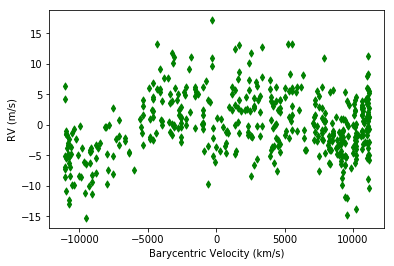

In [10]:
fig, ax = plt.subplots()
ax.scatter(bcs_apf, rvs_to_play_apf, c='green', marker='d')
ax.set_xlabel('Barycentric Velocity (km/s)')
ax.set_ylabel('RV (m/s)')

## De-trend from activity.

In [15]:
data_ours.query('tel == "j"').sval

0      0.1560
1      0.1560
2      0.1560
3      0.1560
4      0.1560
        ...  
105    0.0000
106    0.1597
107    0.1601
108    0.1605
109    0.1601
Name: sval, Length: 110, dtype: float64

(0.12, 0.16)

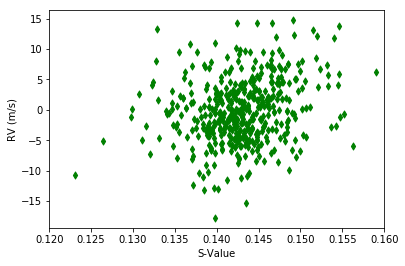

In [84]:
fig, ax = plt.subplots()
ax.scatter(svals_apf, rvs_to_play_apf, c='green', marker='d')
ax.set_xlabel('S-Value')
ax.set_ylabel('RV (m/s)')
ax.set_xlim([0.12, 0.16])

## Make S-value periodograms for long-period candidates.

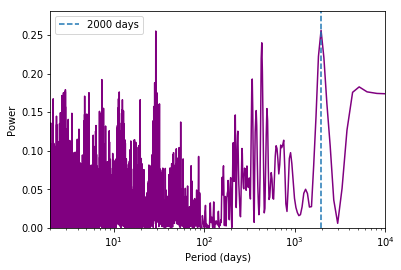

In [87]:
svals = data_all.query('name == "24040" and sval > 0.146').sval
times = data_all.query('name == "24040" and sval > 0.146').jd

frequency, power = LombScargle(times, svals).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple')#, label='S-value periodogram')
ax.axvline(1/frequency[np.argmax(power)], ls='--', 
           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 24040 Activity')

fig.savefig('validation_plots/activity_24040.pdf')

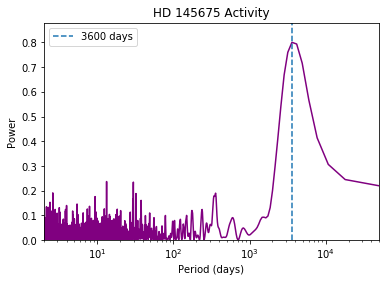

In [59]:
svals = data.query('name == "145675" and sval > 0.12').sval
times = data.query('name == "145675" and sval > 0.12').jd

frequency, power = LombScargle(times, svals).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple')#, label='S-value periodogram')
ax.axvline(1/frequency[np.argmax(power)], ls='--', 
           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 5*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 145675 Activity')

fig.savefig('validation_plots/activity_145675.pdf')

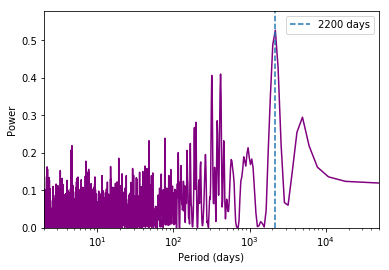

In [4]:
svals = data.query('name == "107148" and sval < 0.17 and sval > 0.15').sval
times = data.query('name == "107148" and sval < 0.17 and sval > 0.15').jd

frequency, power = LombScargle(times, svals).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple')#, label='S-value periodogram')
ax.axvline(1/frequency[np.argmax(power)], ls='--', 
           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 5*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 145675 Activity')

fig.savefig('validation_plots/activity_107148.pdf')

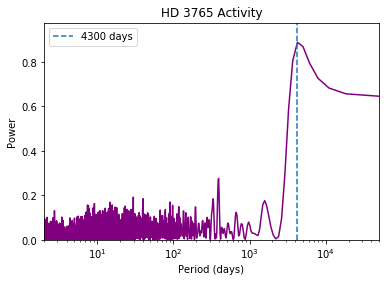

In [66]:
svals = data.query('name == "3765" and sval > 0.12').sval
times = data.query('name == "3765" and sval > 0.12').jd

frequency, power = LombScargle(times, svals).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple')#, label='S-value periodogram')
ax.axvline(1/frequency[np.argmax(power)], ls='--', 
           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 5*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 3765 Activity')#, fontname='Times New Roman')

fig.savefig('validation_plots/activity_3765.pdf')

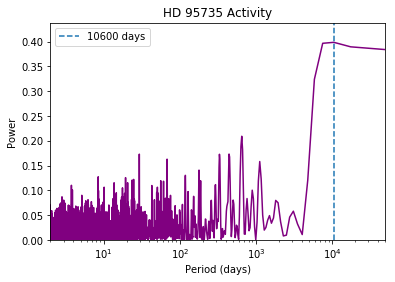

In [55]:
svals = data.query('name == "95735" and sval < 0.8').sval
times = data.query('name == "95735" and sval < 0.8').jd

frequency, power = LombScargle(times, svals).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple')#, label='S-value periodogram')
ax.axvline(1/frequency[np.argmax(power)], ls='--', 
           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 5*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 95735 Activity')

fig.savefig('validation_plots/activity_95735.pdf')

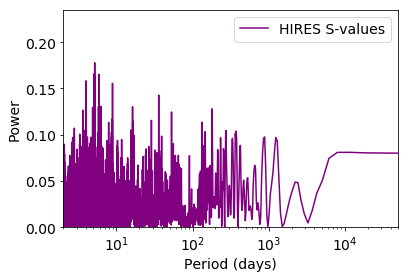

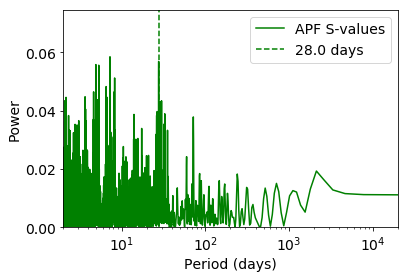

In [20]:
data8 = pd.read_csv('../rvdata/vst86728.csv')
matplotlib.rcParams.update({'font.size': 14})

svals_j = data8.query('tel == "j" and svalue > 0.13').svalue
times_j = data8.query('tel == "j" and svalue > 0.13').jd

svals_a = data8.query('tel == "apf"').svalue
times_a = data8.query('tel == "apf"').jd

frequency, power = LombScargle(times_j, svals_j).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple', label='HIRES S-values')
#ax.axvline(1/frequency[np.argmax(power)], ls='--', 
#           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 5*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 86728 Activity')
fig.savefig('validation_plots/activity_86728_HIRES.pdf')


frequency, power = LombScargle(times_a, svals_a).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='green', label='APF S-values')
ax.axvline(28, ls='--', color='green', label='28.0 days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 2*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 86728 Activity')
fig.savefig('validation_plots/activity_86728_APF.pdf')

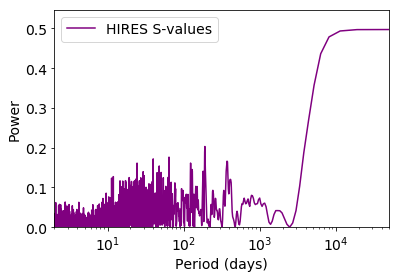

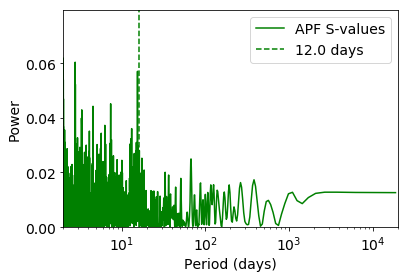

In [26]:
data1 = pd.read_csv('../rvdata/vst164922.csv')
matplotlib.rcParams.update({'font.size': 14})

svals_j = data1.query('tel == "j" and svalue > 0.148').svalue
times_j = data1.query('tel == "j" and svalue > 0.148').jd

svals_a = data1.query('tel == "apf" and svalue > 0.12').svalue
times_a = data1.query('tel == "apf" and svalue > 0.12').jd
#print(svals_a)

frequency, power = LombScargle(times_j, svals_j).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple', label='HIRES S-values')
#ax.axvline(1/frequency[np.argmax(power)], ls='--', 
#           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 5*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 86728 Activity')
fig.savefig('validation_plots/activity_164922_HIRES.pdf')


frequency, power = LombScargle(times_a, svals_a).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='green', label='APF S-values')
ax.axvline(16, ls='--', color='green', label='12.0 days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 2*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 86728 Activity')
fig.savefig('validation_plots/activity_164922_APF.pdf')

## HD 154345. Classic activity mystery.

In [116]:
data = pd.read_csv('../rvdata/vst154345.csv')
post = radvel.posterior.load('special_systems/154345/post_final.pkl')

data = data.query('svalue > 0.16 and cts > 3000')

svals = {}
svals['j'] = data.query('tel == "j"').svalue

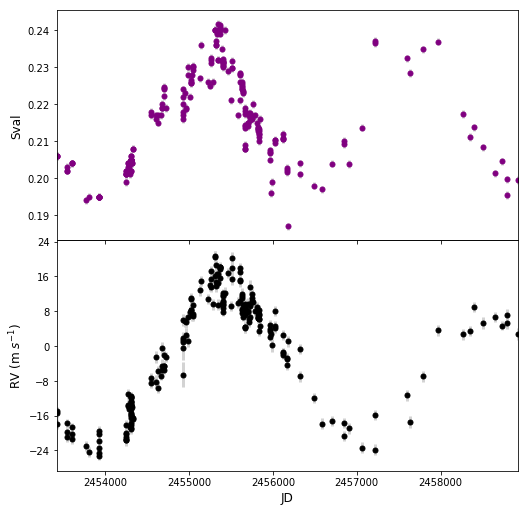

In [117]:
fig = plt.figure(figsize=(8, 8))
#ax1.set_title('', fontsize='x-large')

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.4])
ax1.set_xlabel('JD', fontsize='large')
ax1.set_ylabel(r'RV (m $s^{-1}$)', fontsize='large')
ax1.set_xlim([np.amin(data.jd), np.amax(data.jd)])
ax1.errorbar(data.jd, data.mnvel, yerr=data.errvel, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)

nbins = len(ax1.get_xticklabels()) # added 
ax1.yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))

ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
ax2.set_ylabel('Sval', fontsize='large')
ax2.set_xlim([np.amin(data.jd), np.amax(data.jd)])
ax2.errorbar(data.jd, svals['j'], yerr=0.001, fmt='o', color='purple',
             ecolor='lightgray', elinewidth=3, capsize=0)
ax2.set_xticklabels('')

fig.savefig('special_systems/154345/154345_rvs_and_svals.png', dpi=1000, bbox_inches='tight')
fig.savefig('special_systems/154345/154345_rvs_and_svals.pdf', bbox_inches='tight')

Text(0, 0.5, 'Observation number')

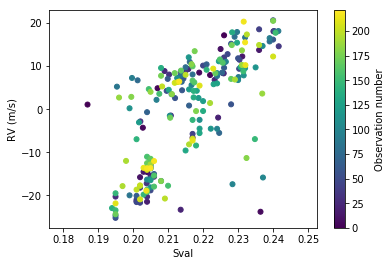

In [92]:
fig, ax = plt.subplots()

ax.set_xlabel('Sval')
ax.set_ylabel('RV (m/s)')

colors = np.arange(len(data))
im = ax.scatter(svals['j'], data.mnvel, c=colors)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Observation number')

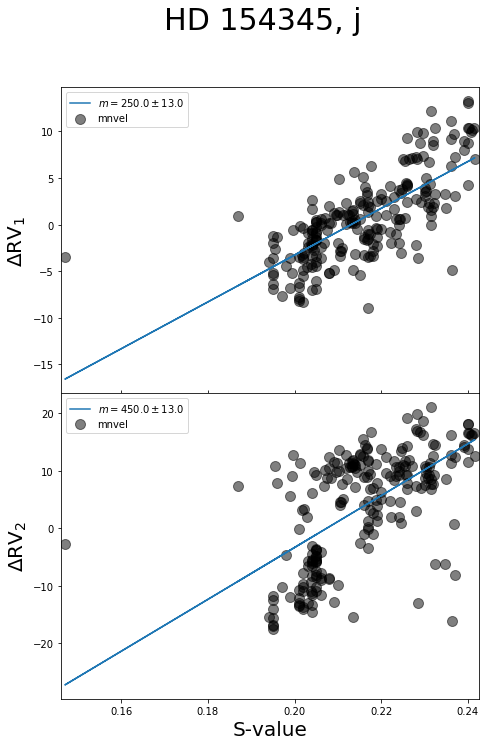

In [79]:
correlator = sval_correlations.Correlator(post, svals, data=data, starname='HD 154345')
correlator.make_all_residuals()

for i in [1, 2]:
    correlator.correlate('j', i)

correlator.stack_one_tel('j')

## Same, for HD 146233.

In [7]:
data = pd.read_csv('../rvdata/vst146233.csv').query('tel == "j" and svalue > 0.125')
svals = {}
svals['j'] = data.query('tel == "j"').svalue

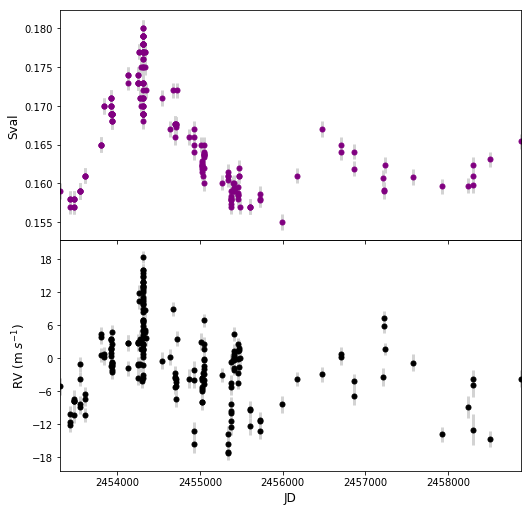

In [8]:
fig = plt.figure(figsize=(8, 8))
#ax1.set_title('', fontsize='x-large')

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.4])
ax1.set_xlabel('JD', fontsize='large')
ax1.set_ylabel(r'RV (m $s^{-1}$)', fontsize='large')
ax1.set_xlim([np.amin(data.jd), np.amax(data.jd)])
ax1.errorbar(data.jd, data.mnvel, yerr=data.errvel, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)

nbins = len(ax1.get_xticklabels()) # added 
ax1.yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))

ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
ax2.set_ylabel('Sval', fontsize='large')
ax2.set_xlim([np.amin(data.jd), np.amax(data.jd)])
ax2.errorbar(data.jd, svals['j'], yerr=0.001, fmt='o', color='purple',
             ecolor='lightgray', elinewidth=3, capsize=0)
ax2.set_xticklabels('')

fig.savefig('special_systems/146233_rvs_and_svals.png', dpi=1000, bbox_inches='tight')
fig.savefig('special_systems/146233_rvs_and_svals.pdf', bbox_inches='tight')

## Same, for HD 114783.

In [2]:
data = pd.read_csv('../rvdata/vst114783.csv').query('tel == "j" and svalue > 0.1')
post = radvel.posterior.load('special_systems/114783/post_final.pkl')

#data = data.query('svalue > 0.16 and cts > 3000')

svals = {}
svals['j'] = data.query('tel == "j"').svalue

orbel1 = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]

mod = radvel.kepler.rv_drive(np.array(data.jd), orbel1)
data['mnvel'] -= mod

#mod1_j = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel1)
#mod1_k = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel1)
#rvs_hires -= mod1_hires + mod2_hires

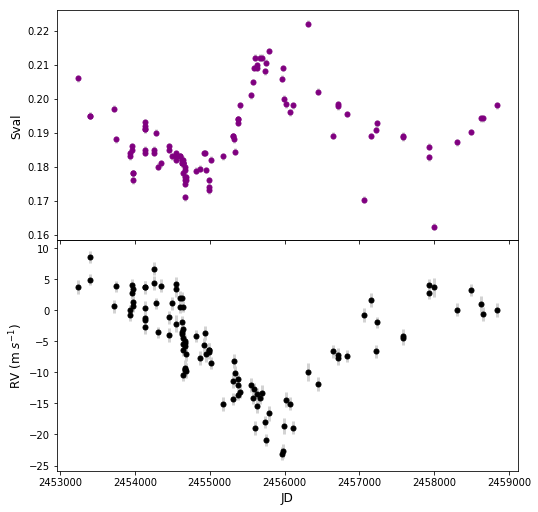

In [3]:
fig = plt.figure(figsize=(8, 8))
#ax1.set_title(r'Giant singles, $M$sin$i$ > 0.1 $M_J$, a > 0.1 AU', fontsize='x-large')

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.4])
ax1.set_xlabel('JD', fontsize='large')
ax1.set_ylabel(r'RV (m $s^{-1}$)', fontsize='large')

ax1.errorbar(data.jd, data.mnvel, yerr=data.errvel, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)

nbins = len(ax1.get_xticklabels()) # added 
ax1.yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))

ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
ax2.set_ylabel('Sval', fontsize='large')
#ax2.set_xlim([0, 1])
#ax2.set_ylim([0, 4])
ax2.errorbar(data.jd, svals['j'], yerr=0.001, fmt='o', color='purple',
             ecolor='lightgray', elinewidth=3, capsize=0)
ax2.set_xticklabels('')

fig.savefig('special_systems/114783/114783_rvs_and_svals.png', dpi=1000, bbox_inches='tight')
fig.savefig('special_systems/114783/114783_rvs_and_svals.pdf', bbox_inches='tight')

In [6]:
data = pd.read_csv('../rvdata/vst26965.csv').query('tel == "j" and svalue > 0.14')
post = radvel.posterior.load('special_systems/26965/post_final.pkl')

#data = data.query('svalue > 0.16 and cts > 3000')

svals = {}
svals['j'] = data.query('tel == "j"').svalue

orbel1 = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]

mod = radvel.kepler.rv_drive(np.array(data.jd), orbel1)
data['mnvel'] -= mod

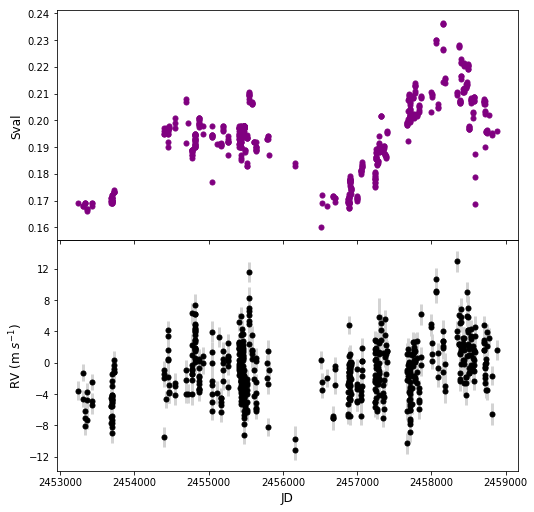

In [7]:
fig = plt.figure(figsize=(8, 8))
#ax1.set_title(r'Giant singles, $M$sin$i$ > 0.1 $M_J$, a > 0.1 AU', fontsize='x-large')

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.4])
ax1.set_xlabel('JD', fontsize='large')
ax1.set_ylabel(r'RV (m $s^{-1}$)', fontsize='large')

ax1.errorbar(data.jd, data.mnvel, yerr=data.errvel, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)

nbins = len(ax1.get_xticklabels()) # added 
ax1.yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))

ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
ax2.set_ylabel('Sval', fontsize='large')
#ax2.set_xlim([0, 1])
#ax2.set_ylim([0, 4])
ax2.errorbar(data.jd, svals['j'], yerr=0.001, fmt='o', color='purple',
             ecolor='lightgray', elinewidth=3, capsize=0)
ax2.set_xticklabels('')

fig.savefig('special_systems/26965/26965_rvs_and_svals.png', dpi=1000, bbox_inches='tight')
fig.savefig('special_systems/26965/26965_rvs_and_svals.pdf', bbox_inches='tight')

## HD 192310. Known planets at 74 and 525 days, 2nd may be activity.

In [12]:
data = pd.read_csv('../rvdata/vst192310.csv')
post = radvel.posterior.load('special_systems/192310/post_final.pkl')

data = data.query('svalue > 0.14')

svals = {}
#svals['k'] = data.query('tel == "k"').svalue
svals['j'] = data.query('tel == "j"').svalue

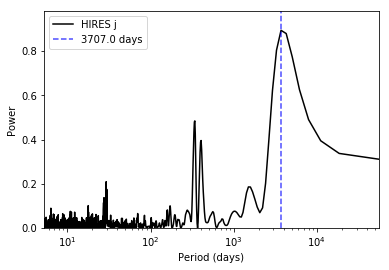

In [13]:
frequency, power = LombScargle(data.query('tel == "j"').jd, svals['j']).autopower()

fig, ax = plt.subplots()
#ax.set_title('HD 1457675 S-value periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')

ax.set_xlim([np.amin(1/frequency), np.amax(1/frequency)])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xscale('log')

ax.plot(1/frequency, power, c='black', label='HIRES j')
ax.axvline(1/frequency[np.argmax(power)], ls='--', c='blue', 
           alpha=0.7, label='{} days'.format(np.round(1/frequency[np.argmax(power)], decimals=0)))
ax.legend()
fig.savefig('special_systems/192310/sval_periodogram.png', dpi=500)

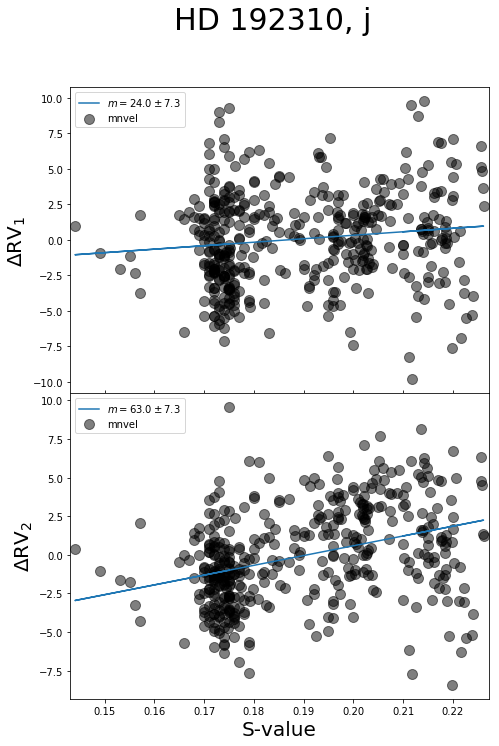

In [14]:
correlator = sval_correlations.Correlator(post, svals, data=data, starname='HD 192310')
correlator.make_all_residuals()

for i in [1, 2]:
    correlator.correlate('j', i)
    #correlator.correlate('apf', i)

correlator.stack_one_tel('j')
#correlator.stack_one_tel('apf')

# Look at PSF/BC correlations for possible yearly aliases.

In [32]:
def correlate(psf, mnvel, errvel):
    
    # Linear slope
    A   = np.vander(psf, 2)
    C   = np.diag(errvel * errvel)
    ATA = np.dot(A.T, A / (errvel**2)[:, None])
    cov = np.linalg.inv(ATA)
    w   = np.linalg.solve(ATA, np.dot(A.T, mnvel / errvel**2))  
    
    m = w[0]
    b = w[1]
    sigm = np.sqrt(cov[0, 0])
    sigb = np.sqrt(cov[1, 1])
    
    # Pearson correlation.
    mux  = np.mean(psf)
    muy  = np.mean(mnvel)
    E    = np.mean((psf - mux)*(mnvel - muy))
    sigx = np.std(psf)
    sigy = np.std(mnvel)
    rho  = E/(sigx*sigy)
    return [b, m, sigb, sigm, rho]


## HD 95735. 1 Known planet, 2 outer candidates, one is likely APF systematics. ~210 days.

In [50]:
data = data_all.query('name == "95735" and cts > 3000').reset_index(drop=True)
data_hires = data.query('tel == "j"')
data_apf   = data.query('tel == "apf" and psf11 < 0.025 and psf11 > -0.025 \
                         and psf12 < 0.02 and psf12 > -0.017 and psf2 < 0.05 \
                         and psf1 > -0.01 and psf3 > -0.02').reset_index()
post = radvel.posterior.load('special_systems/95735/post_final.pkl')

times       = np.array(data_hires.jd)
psf1_hires  = np.array(data_hires.psf1)
psf2_hires  = np.array(data_hires.psf2)
psf3_hires  = np.array(data_hires.psf3)
psf4_hires  = np.array(data_hires.psf4)
psf5_hires  = np.array(data_hires.psf5)
psf6_hires  = np.array(data_hires.psf6)
psf7_hires  = np.array(data_hires.psf7)
psf8_hires  = np.array(data_hires.psf8)
psf9_hires  = np.array(data_hires.psf9)
psf10_hires = np.array(data_hires.psf10)
psf11_hires = np.array(data_hires.psf11)
psf12_hires = np.array(data_hires.psf12)

psfs = [psf1_hires, psf2_hires, psf3_hires,
        psf4_hires, psf5_hires, psf6_hires,
        psf7_hires, psf8_hires, psf9_hires,
        psf10_hires, psf11_hires, psf12_hires]

times_apf = np.array(data_apf.jd)
psf1_apf  = np.array(data_apf.psf1)
psf2_apf  = np.array(data_apf.psf2)
psf3_apf  = np.array(data_apf.psf3)
psf4_apf  = np.array(data_apf.psf4)
psf5_apf  = np.array(data_apf.psf5)
psf6_apf  = np.array(data_apf.psf6)
psf7_apf  = np.array(data_apf.psf7)
psf8_apf  = np.array(data_apf.psf8)
psf9_apf  = np.array(data_apf.psf9)
psf10_apf = np.array(data_apf.psf10)
psf11_apf = np.array(data_apf.psf11)
psf12_apf = np.array(data_apf.psf12)

psfs_apf = [psf1_apf, psf2_apf, psf3_apf,
            psf4_apf, psf5_apf, psf6_apf,
            psf7_apf, psf8_apf, psf9_apf,
            psf10_apf, psf11_apf, psf12_apf]

rvs_hires   = np.array(data_hires.mnvel)
errvels_hires = np.sqrt((np.array(data_hires.errvel))**2 + \
                           post.params['jit_j'].value**2)
rvs_apf     = np.array(data_apf.mnvel)
errvels_apf = np.sqrt((np.array(data_apf.errvel))**2 + \
                       post.params['jit_apf'].value**2)
bcs_hires   = np.array(data_hires.bc)
bcs_apf     = np.array(data_apf.bc)
svals_hires = np.array(data_hires.SVAL) # svalue for individual set
svals_apf   = np.array(data_apf.SVAL)
chis_hires  = np.array(data_hires.mdchi)
chis_apf    = np.array(data_apf.mdchi)

orbel1 = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]
orbel2 = [post.params['per2'].value,
         post.params['tp2'].value,
         post.params['e2'].value,
         post.params['w2'].value,
         post.params['k2'].value]

mod1_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel1)
mod1_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel1)
mod2_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel2)
mod2_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel2)
rvs_hires -= mod1_hires + mod2_hires
rvs_apf   -= mod1_apf + mod2_apf

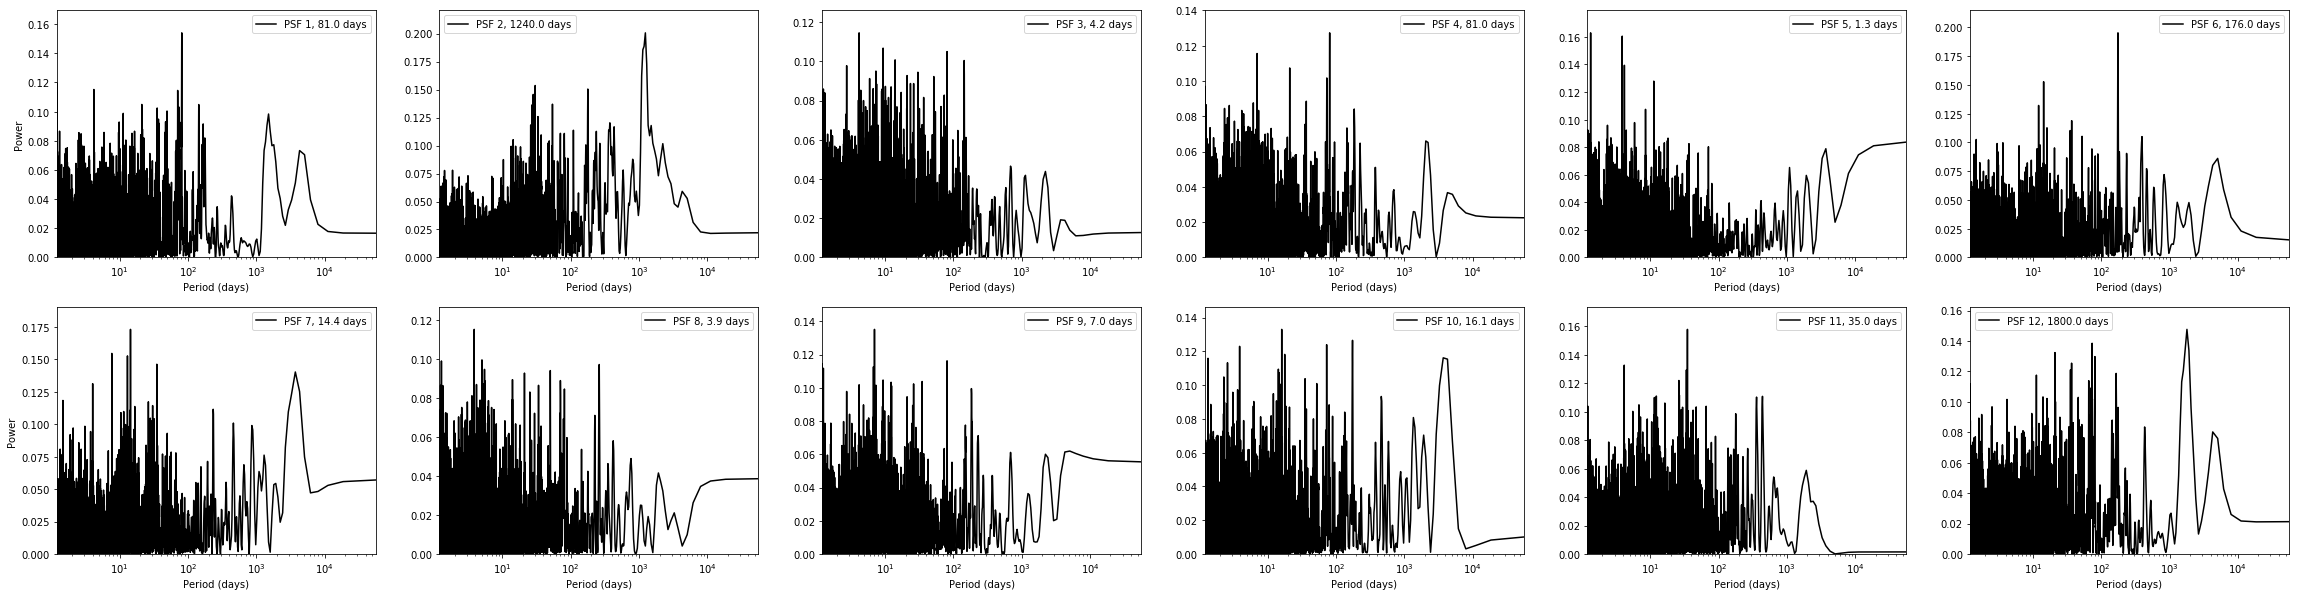

In [34]:
fig, axes = plt.subplots(2, 6, figsize=(40, 10))
frequency = np.logspace(np.log(1.2), 4*np.log(10), num=10**4)
for i in np.arange(2):
    for j in np.arange(6):
        index = j + 6*i
        psf = psfs[index]
        #power = LombScargle(times, psf).power(frequency)#autopower, nyquist_factor=100)
        frequency, power = LombScargle(times, psf).autopower(nyquist_factor=100)
        power = power[1/frequency >= 1.2]
        frequency = frequency[1/frequency >= 1.2]
        Pmax = round(1/frequency[np.argmax(power)], 1)
        
        if j == 0:
            axes[i][j].set_ylabel('Power')
        axes[i][j].set_xlabel('Period (days)') 
                
        axes[i][j].plot(1/frequency, power, c='black',
                        label = 'PSF {}, {} days'.format(index+1, Pmax))
        axes[i][j].set_xscale('log')
        axes[i][j].set_xlim([1.2, np.amax(1/frequency)])
        axes[i][j].set_ylim([0, 1.1*np.amax(power)])
        axes[i][j].legend()

fig.savefig('special_systems/95735_grid_periodogram_hires.png', dpi=200)

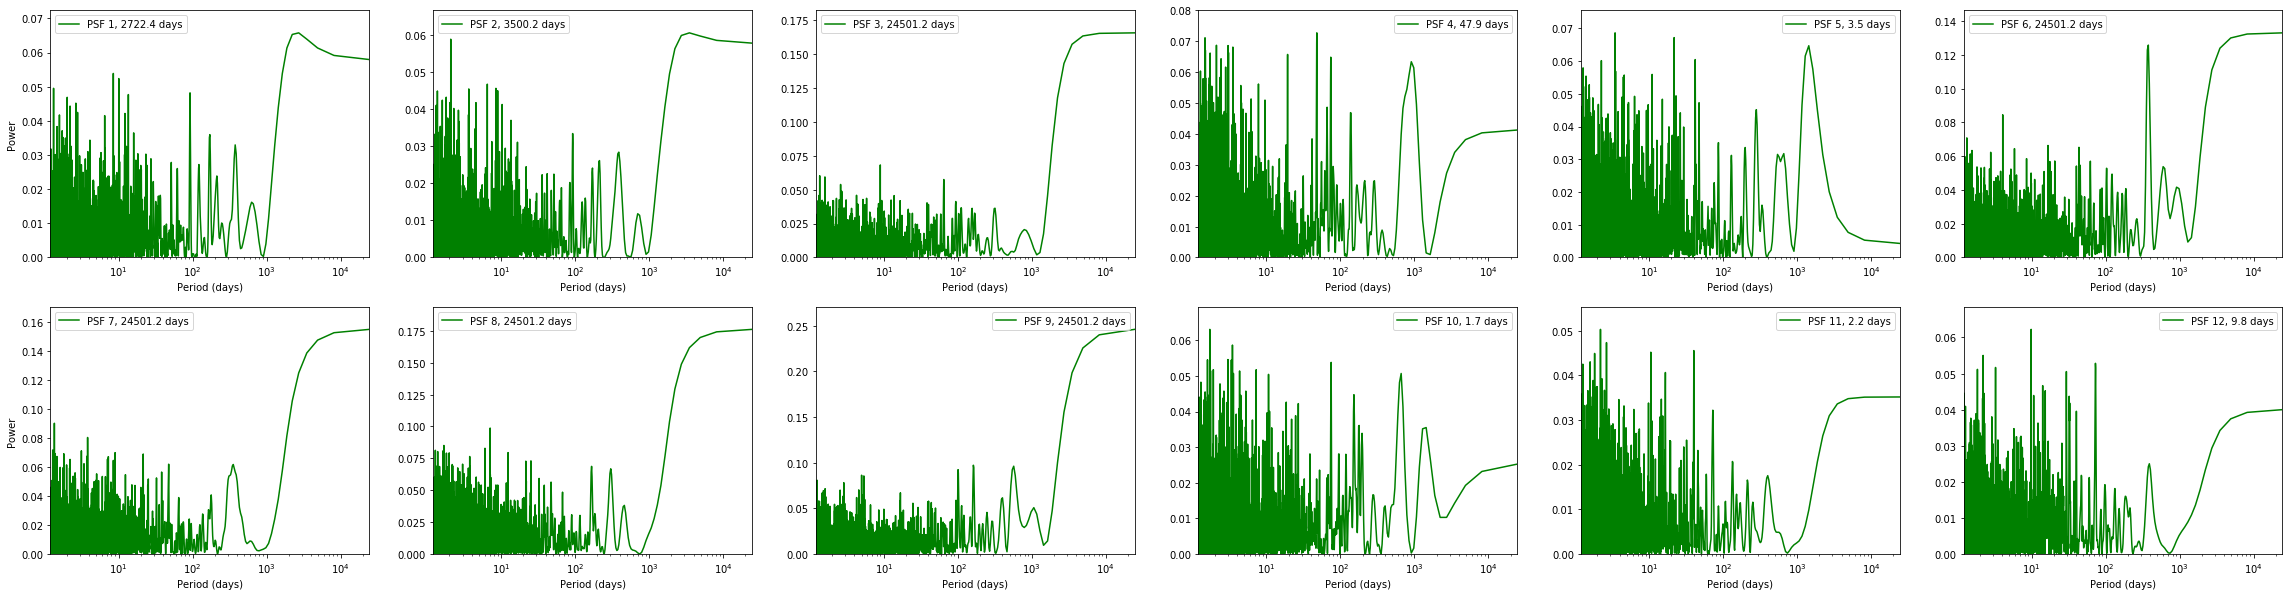

In [51]:
fig, axes = plt.subplots(2, 6, figsize=(40, 10))
frequency = np.logspace(np.log(1.2), 4*np.log(10), num=10**4)
for i in np.arange(2):
    for j in np.arange(6):
        index = j + 6*i
        psf = psfs_apf[index]
        #power = LombScargle(times, psf).power(frequency)#autopower, nyquist_factor=100)
        frequency, power = LombScargle(times_apf, psf).autopower(nyquist_factor=100)
        power = power[1/frequency >= 1.2]
        frequency = frequency[1/frequency >= 1.2]
        Pmax = round(1/frequency[np.argmax(power)], 1)
        
        if j == 0:
            axes[i][j].set_ylabel('Power')
        axes[i][j].set_xlabel('Period (days)') 
                
        axes[i][j].plot(1/frequency, power, c='green',
                        label = 'PSF {}, {} days'.format(index+1, Pmax))
        axes[i][j].set_xscale('log')
        axes[i][j].set_xlim([1.2, np.amax(1/frequency)])
        axes[i][j].set_ylim([0, 1.1*np.amax(power)])
        axes[i][j].legend()

fig.savefig('special_systems/95735_grid_periodogram_apf.png', dpi=200)

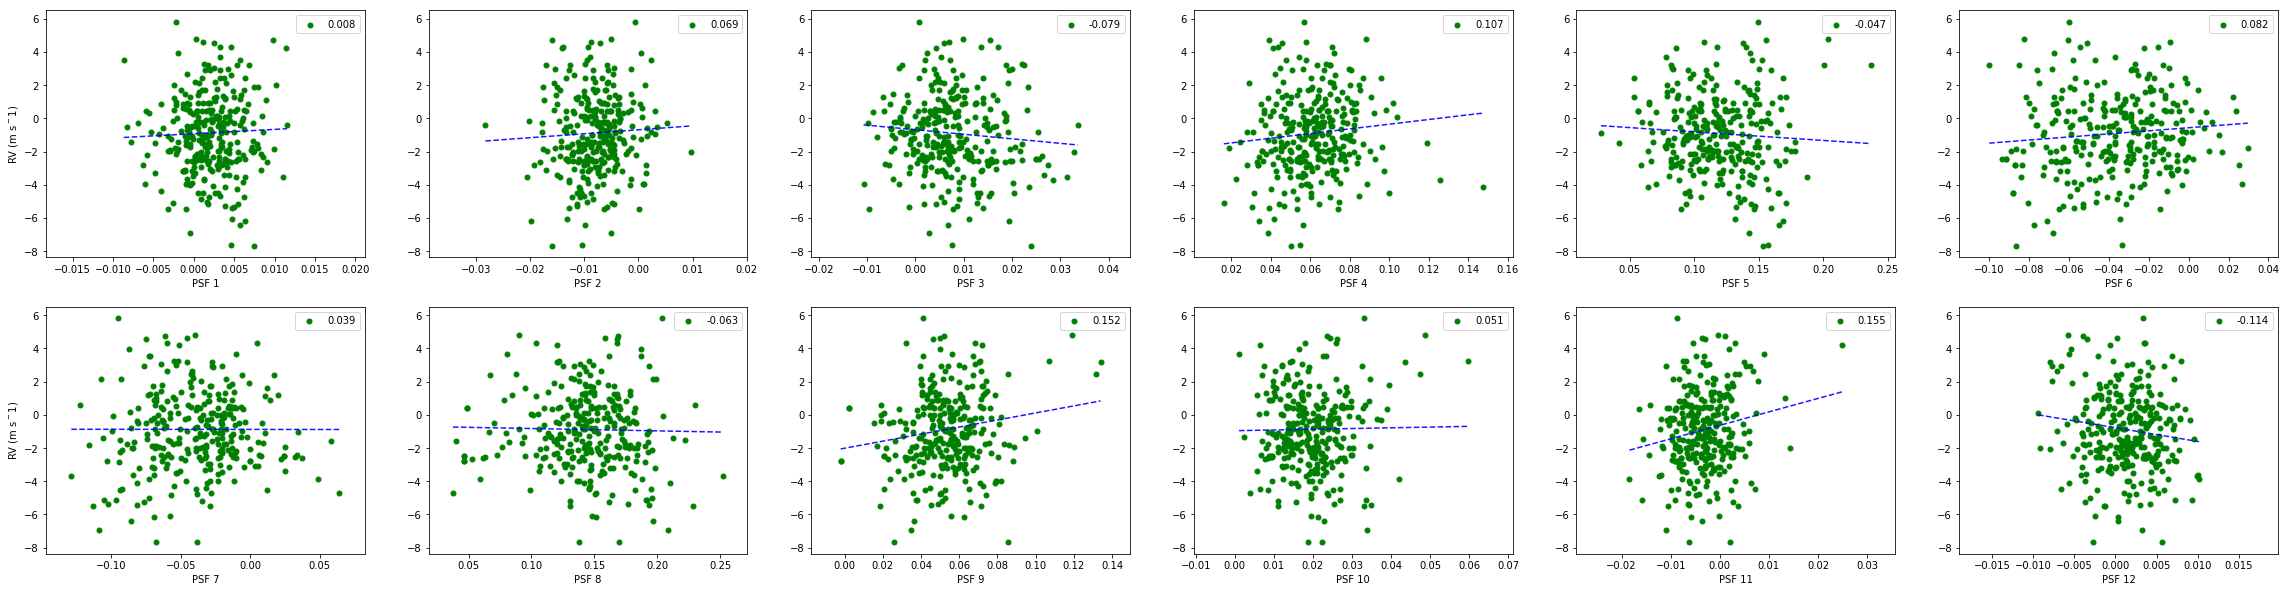

In [52]:
fig, axes = plt.subplots(2, 6, figsize=(40, 10))
for i in np.arange(2):
    for j in np.arange(6):
        index = j + 6*i
        psf = psfs_apf[index]
        correlater = correlate(psf, rvs_apf, errvels_apf)
        
        if j == 0:
            axes[i][j].set_ylabel(r'RV (m s$^-1$)')
        axes[i][j].set_xlabel('PSF {}'.format(index + 1) )            
        axes[i][j].scatter(psf, rvs_apf, c='green', marker='o',
                           label = str(round(correlater[4], 3)))

        axes[i][j].legend()
        x = np.linspace(np.amin(psf), np.amax(psf), 50)
        axes[i][j].plot(x, correlater[1]*x + correlater[0], 
                        ls='--', alpha=0.9, c='blue')

fig.savefig('special_systems/95735_grid_apf.png', dpi=200)

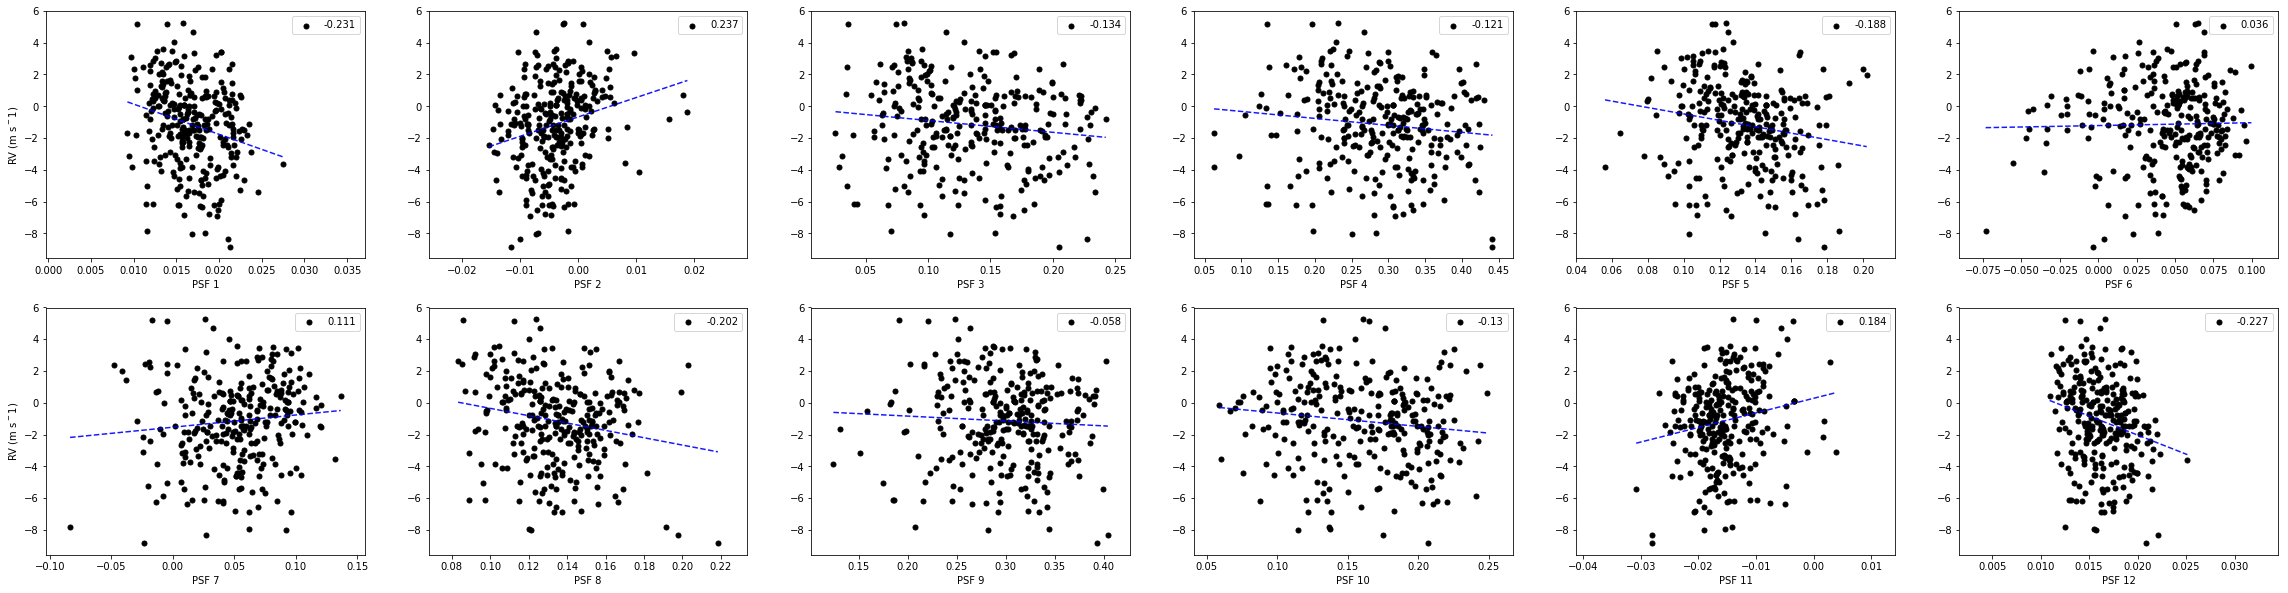

In [53]:
fig, axes = plt.subplots(2, 6, figsize=(40, 10))
for i in np.arange(2):
    for j in np.arange(6):
        index = j + 6*i
        psf = psfs[index]
        correlater = correlate(psf, rvs_hires, errvels_hires)
        
        if j == 0:
            axes[i][j].set_ylabel(r'RV (m s$^-1$)')
        axes[i][j].set_xlabel('PSF {}'.format(index + 1) )            
        axes[i][j].scatter(psf, rvs_hires, c='black', marker='o',
                           label = str(round(correlater[4], 3)))

        axes[i][j].legend()
        x = np.linspace(np.amin(psf), np.amax(psf), 50)
        axes[i][j].plot(x, correlater[1]*x + correlater[0], 
                        ls='--', alpha=0.9, c='blue')

fig.savefig('special_systems/95735_grid_hires.png', dpi=200)

## HD 115617. 3 Known planets, outer is 122 days. Two RVSearch peaks of equal height at ~91 and ~122 days, yearly systematics suspected.

In [63]:
#data = pd.read_csv('../rvdata/vst115617.csv').query('cts > 3000')
data = data_all.query('name == "115617" and cts > 3000').reset_index(drop=True)
data_hires = data.query('tel == "j" and psf1 < 0.03 and psf12 < 0.025 \
                         and psf2 < 0.018 and psf2 > -0.03 and psf8 < 0.25 \
                         and psf11 > -0.03')
data_apf   = data.query('tel == "apf"').reset_index()
post = radvel.posterior.load('special_systems/115617/post_final.pkl')

times       = np.array(data_hires.jd)
psf1_hires  = np.array(data_hires.psf1)
psf2_hires  = np.array(data_hires.psf2)
psf3_hires  = np.array(data_hires.psf3)
psf4_hires  = np.array(data_hires.psf4)
psf5_hires  = np.array(data_hires.psf5)
psf6_hires  = np.array(data_hires.psf6)
psf7_hires  = np.array(data_hires.psf7)
psf8_hires  = np.array(data_hires.psf8)
psf9_hires  = np.array(data_hires.psf9)
psf10_hires = np.array(data_hires.psf10)
psf11_hires = np.array(data_hires.psf11)
psf12_hires = np.array(data_hires.psf12)

psfs = [psf1_hires, psf2_hires, psf3_hires,
        psf4_hires, psf5_hires, psf6_hires,
        psf7_hires, psf8_hires, psf9_hires,
        psf10_hires, psf11_hires, psf12_hires]

rvs_hires   = np.array(data_hires.mnvel)
errvels_hires = np.sqrt((np.array(data_hires.errvel))**2 + \
                           post.params['jit_j'].value**2)
rvs_apf     = np.array(data_apf.mnvel)
bcs_hires   = np.array(data_hires.bc)
bcs_apf     = np.array(data_apf.bc)
svals_hires = np.array(data_hires.SVAL) # svalue for individual set
svals_apf   = np.array(data_apf.SVAL)
chis_hires  = np.array(data_hires.mdchi)
chis_apf    = np.array(data_apf.mdchi)

orbel1 = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]
orbel2 = [post.params['per2'].value,
         post.params['tp2'].value,
         post.params['e2'].value,
         post.params['w2'].value,
         post.params['k2'].value]

mod1_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel1)
mod1_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel1)
mod2_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel2)
mod2_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel2)
rvs_hires -= mod1_hires + mod2_hires
rvs_apf   -= mod1_apf + mod2_apf

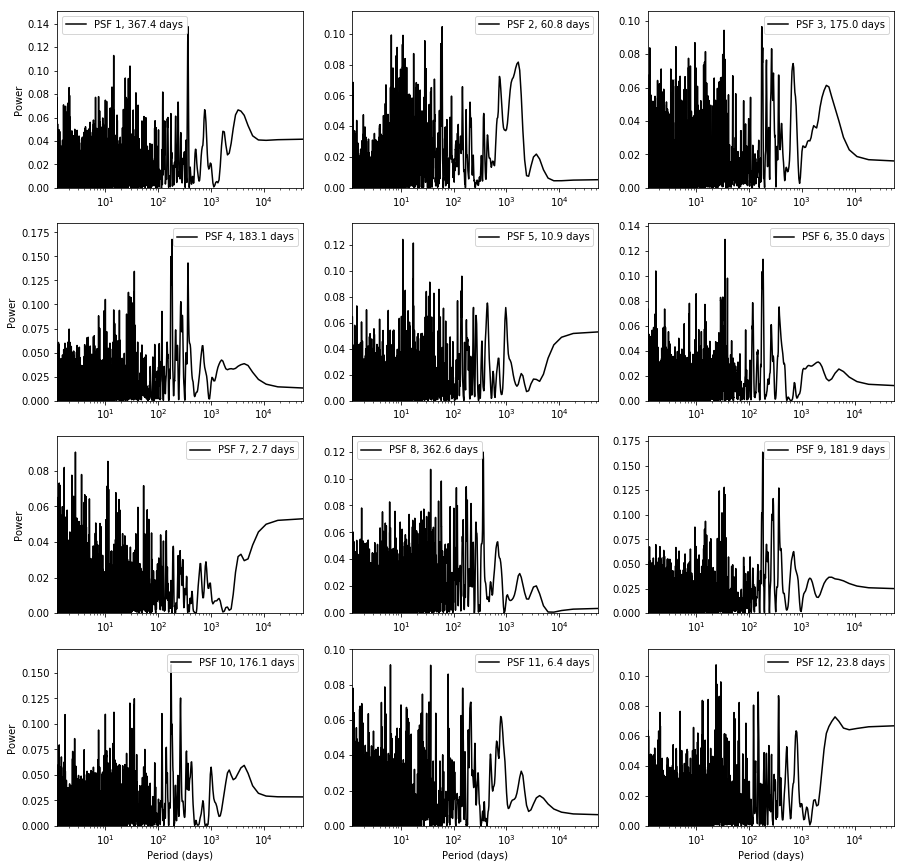

In [77]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))#(40, 10))
frequency = np.logspace(np.log(1.2), 4*np.log(10), num=10**4)
for i in np.arange(4): #2
    for j in np.arange(3): #6
        #index = j + 6*i
        index = j + 3*i
        psf = psfs[index]
        #power = LombScargle(times, psf).power(frequency)#autopower, nyquist_factor=100)
        frequency, power = LombScargle(times, psf).autopower(nyquist_factor=100)
        power = power[1/frequency >= 1.2]
        frequency = frequency[1/frequency >= 1.2]
        Pmax = round(1/frequency[np.argmax(power)], 1)
        
        if j == 0:
            axes[i][j].set_ylabel('Power')
        if i == 3:
            axes[i][j].set_xlabel('Period (days)') 
                
        axes[i][j].plot(1/frequency, power, c='black',
                        label = 'PSF {}, {} days'.format(index+1, Pmax))
        axes[i][j].set_xscale('log')
        axes[i][j].set_xlim([1.2, np.amax(1/frequency)])
        axes[i][j].set_ylim([0, 1.1*np.amax(power)])
        axes[i][j].legend()

fig.savefig('special_systems/115617_grid_periodogram.png', dpi=200)

0
1
2
3
4
5
6
7
8
9
10
11


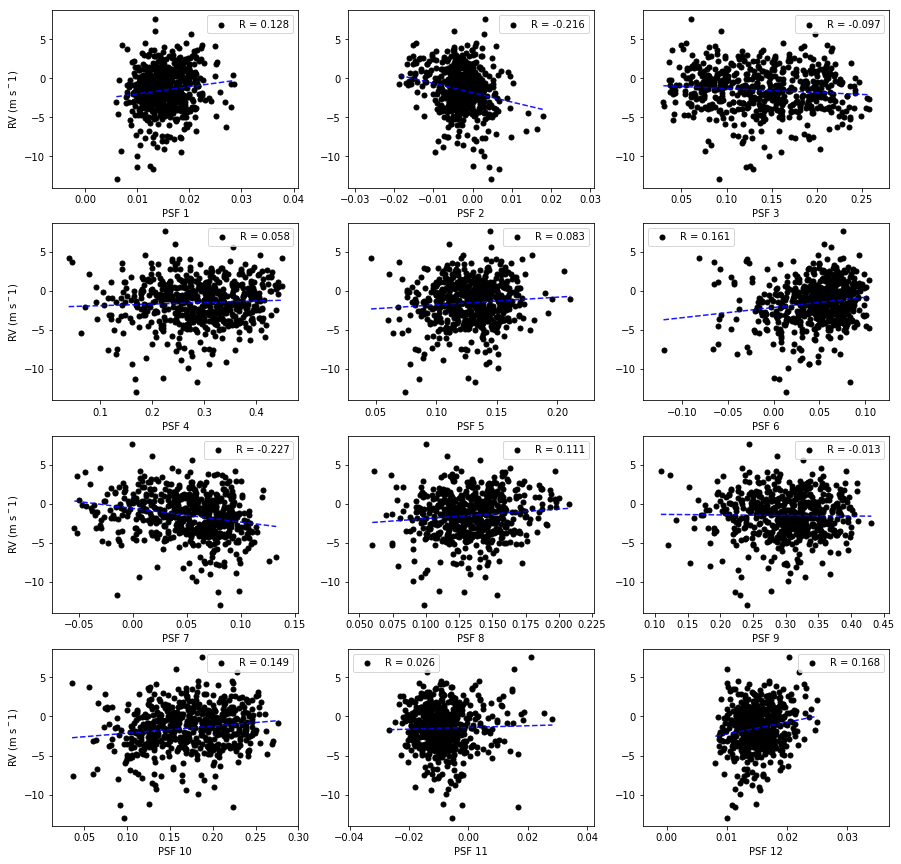

In [74]:
#fig, axes = plt.subplots(2, 6, figsize=(40, 10))
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
for i in np.arange(4):
    for j in np.arange(3):
        #index = j + 6*i
        index = j + 3*i
        print(index)
        psf = psfs[index]
        correlater = correlate(psf, rvs_hires, errvels_hires)
        
        if j == 0:
            axes[i][j].set_ylabel(r'RV (m s$^-1$)')
        axes[i][j].set_xlabel('PSF {}'.format(index + 1) )            
        axes[i][j].scatter(psf, rvs_hires, c='black', marker='o',
                           label = 'R = ' + str(round(correlater[4], 3)))
        #                   label = r'{}$\sigma$'.format(
        #                   round(abs(correlater[1])/correlater[3], 1)))
        axes[i][j].legend()
        x = np.linspace(np.amin(psf), np.amax(psf), 50)
        axes[i][j].plot(x, correlater[1]*x + correlater[0], 
                        ls='--', alpha=0.9, c='blue')
        
fig.savefig('special_systems/115617_grid.png', dpi=200)

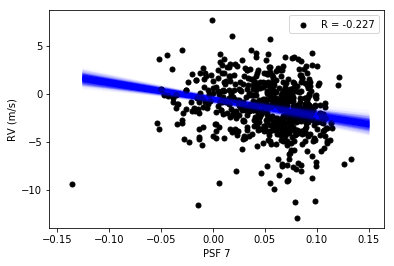

In [61]:
correlate7 = correlate(psf7_hires, rvs_hires, errvels_hires)
x = np.linspace(-0.125, 0.15, 50)

fig, ax = plt.subplots()
ax.scatter(psf7_hires, rvs_hires, c='black', marker='o',
           label = 'R = ' + str(round(correlater[4], 3)))
ax.legend()
for i in np.arange(1000):
    b = np.random.normal(correlate7[0], correlate7[2])
    m = np.random.normal(correlate7[1], correlate7[3])
    ax.plot(x, m*x + b, alpha=0.01, c='blue')
    
ax.set_xlabel('PSF 7')
ax.set_ylabel('RV (m/s)')
fig.savefig('special_systems/115617/psf7_rvs_hires.png', dpi=200)

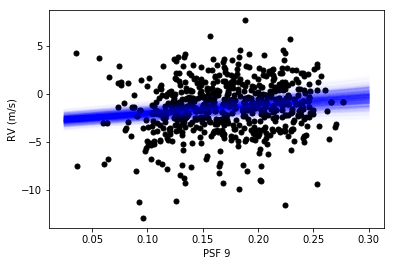

In [111]:
correlate9 = correlate(psf9_hires, rvs_hires, errvels_hires)
x = np.linspace(0.025, 0.3, 50)

fig, ax = plt.subplots()
ax.scatter(psf9_hires, rvs_hires, c='black', marker='o')
for i in np.arange(1000):
    b = np.random.normal(correlate9[0], correlate9[2])
    m = np.random.normal(correlate9[1], correlate9[3])
    ax.plot(x, m*x + b, alpha=0.01, c='blue')
    
ax.set_xlabel('PSF 9')
ax.set_ylabel('RV (m/s)')
fig.savefig('special_systems/115617/psf9_rvs_hires.png', dpi=200)

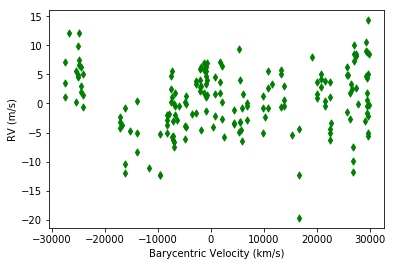

In [83]:
fig, ax = plt.subplots()
ax.scatter(bcs_apf, rvs_apf, c='green', marker='d')
ax.set_xlabel('Barycentric Velocity (km/s)')
ax.set_ylabel('RV (m/s)')
fig.savefig('special_systems/115617/bcs_rvs_apf.png', dpi=200)

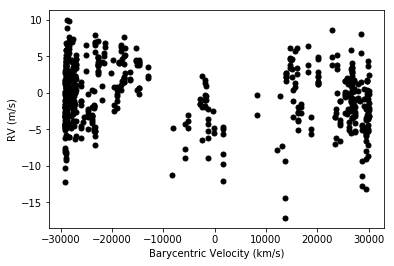

In [82]:
fig, ax = plt.subplots()
ax.scatter(bcs_hires, rvs_hires, c='black', marker='o')
ax.set_xlabel('Barycentric Velocity (km/s)')
ax.set_ylabel('RV (m/s)')
fig.savefig('special_systems/115617/bcs_rvs_hires.png', dpi=200)

In [56]:
data = data_all.query('name == "69830" and cts > 3000').reset_index(drop=True)
#data_hires = data.query('tel == "j" and psf1 < 0.04 and psf3 < 0.025 \
#                         and psf7 > -0.1 and psf10 > -0.03').reset_index()
data_hires = data.query('tel == "j"').reset_index()
data_apf   = data.query('tel == "apf"').reset_index()
post = radvel.posterior.load('special_systems/69830/post_final.pkl')

times       = np.array(data_hires.jd)
psf1_hires  = np.array(data_hires.psf1)
psf2_hires  = np.array(data_hires.psf2)
psf3_hires  = np.array(data_hires.psf3)
psf4_hires  = np.array(data_hires.psf4)
psf5_hires  = np.array(data_hires.psf5)
psf6_hires  = np.array(data_hires.psf6)
psf7_hires  = np.array(data_hires.psf7)
psf8_hires  = np.array(data_hires.psf8)
psf9_hires  = np.array(data_hires.psf9)
psf10_hires = np.array(data_hires.psf10)
psf11_hires = np.array(data_hires.psf11)
psf12_hires = np.array(data_hires.psf12)

psfs = [psf1_hires, psf2_hires, psf3_hires,
        psf4_hires, psf5_hires, psf6_hires,
        psf7_hires, psf8_hires, psf9_hires,
        psf10_hires, psf11_hires, psf12_hires]

rvs_hires   = np.array(data_hires.mnvel)
errvels_hires = np.sqrt((np.array(data_hires.errvel))**2 + \
                           post.params['jit_j'].value**2)
rvs_apf     = np.array(data_apf.mnvel)
bcs_hires   = np.array(data_hires.bc)
bcs_apf     = np.array(data_apf.bc)
svals_hires = np.array(data_hires.SVAL) # svalue for individual set
svals_apf   = np.array(data_apf.SVAL)
chis_hires  = np.array(data_hires.mdchi)
chis_apf    = np.array(data_apf.mdchi)

orbel1 = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]
orbel2 = [post.params['per2'].value,
         post.params['tp2'].value,
         post.params['e2'].value,
         post.params['w2'].value,
         post.params['k2'].value]

mod1_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel1)
mod1_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel1)
mod2_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel2)
mod2_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel2)
rvs_hires -= mod1_hires + mod2_hires
rvs_apf   -= mod1_apf + mod2_apf

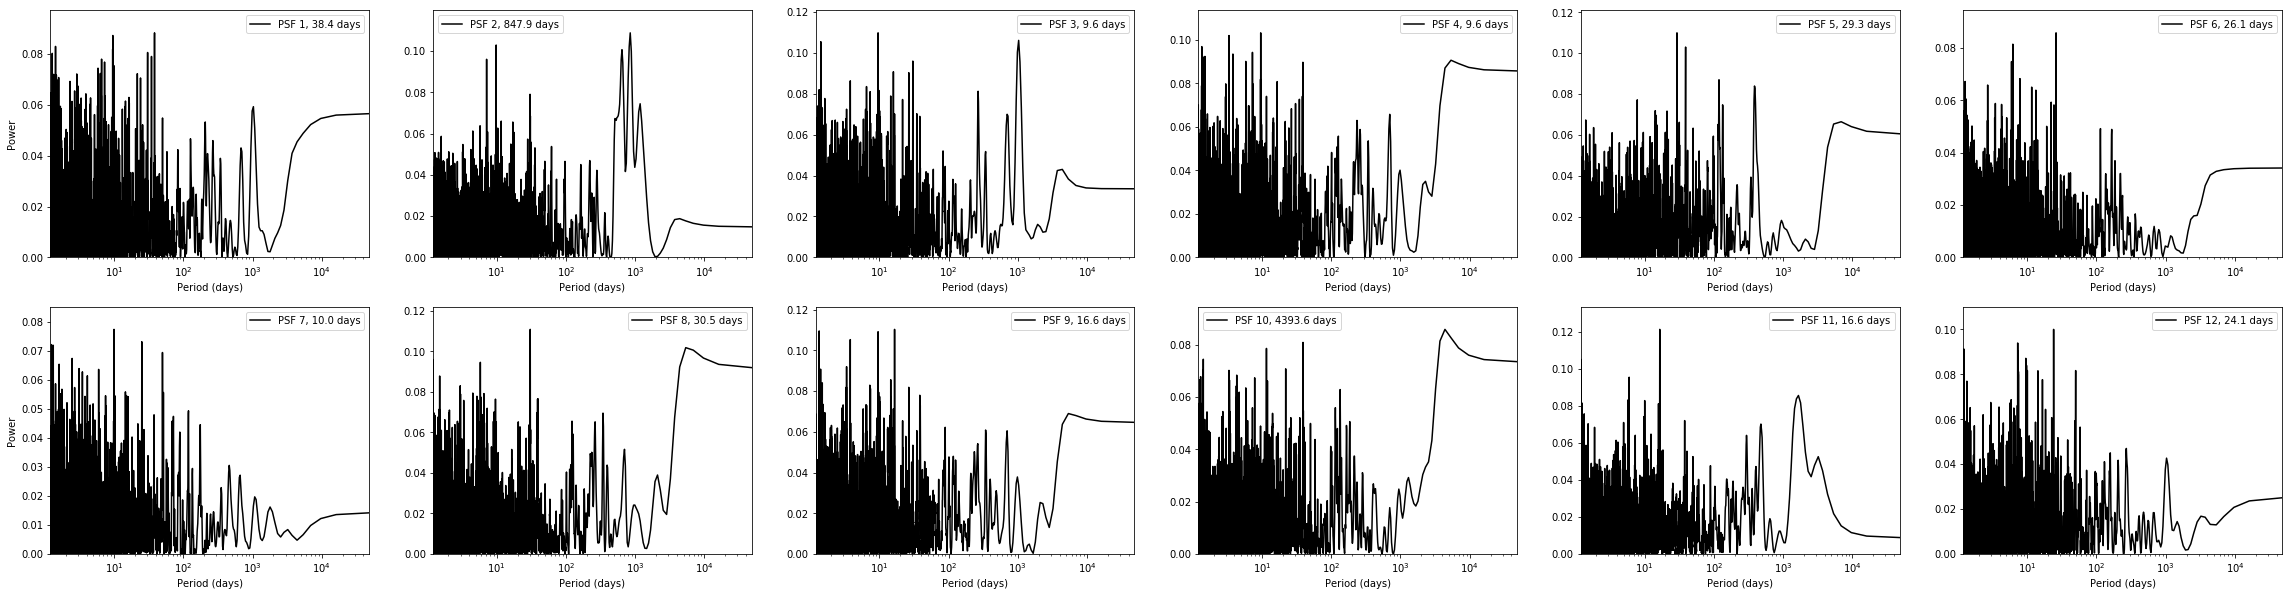

In [57]:
fig, axes = plt.subplots(2, 6, figsize=(40, 10))
frequency = np.logspace(np.log(1.2), 4*np.log(10), num=10**4)
for i in np.arange(2):
    for j in np.arange(6):
        index = j + 6*i
        psf = psfs[index]
        #power = LombScargle(times, psf).power(frequency)#autopower, nyquist_factor=100)
        frequency, power = LombScargle(times, psf).autopower(nyquist_factor=100)
        power = power[1/frequency >= 1.2]
        frequency = frequency[1/frequency >= 1.2]
        Pmax = round(1/frequency[np.argmax(power)], 1)
        
        if j == 0:
            axes[i][j].set_ylabel('Power')
        axes[i][j].set_xlabel('Period (days)') 
                
        axes[i][j].plot(1/frequency, power, c='black',
                        label = 'PSF {}, {} days'.format(index+1, Pmax))
        axes[i][j].set_xscale('log')
        axes[i][j].set_xlim([1.2, np.amax(1/frequency)])
        axes[i][j].set_ylim([0, 1.1*np.amax(power)])
        axes[i][j].legend()

fig.savefig('69830_grid_periodogram.png', dpi=200)

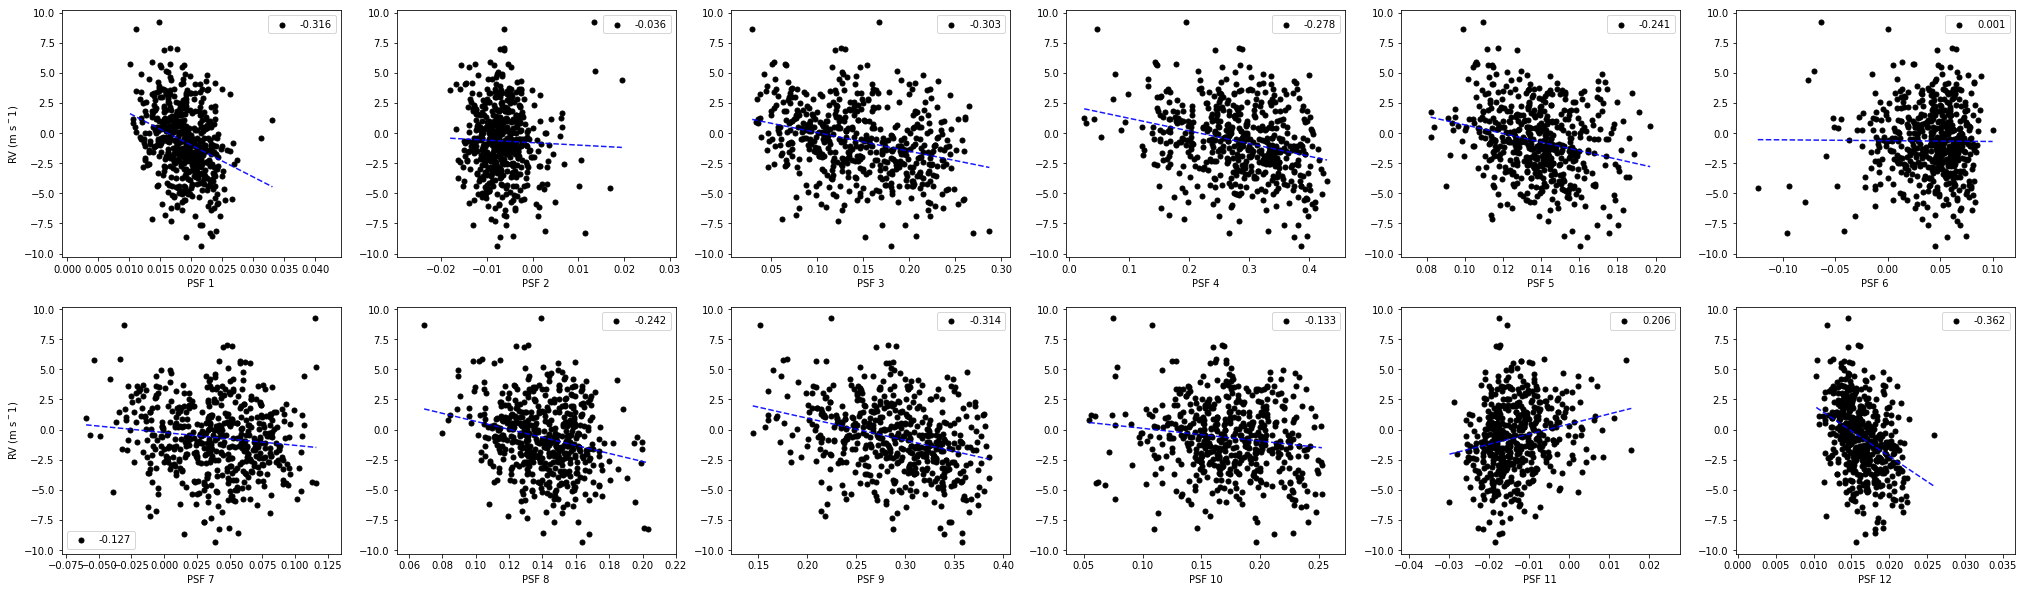

In [233]:
fig, axes = plt.subplots(2, 6, figsize=(35, 10))
for i in np.arange(2):
    for j in np.arange(6):
        index = j + 6*i
        psf = psfs[index]
        correlater = correlate(psf, rvs_hires, errvels_hires)
        
        if j == 0:
            axes[i][j].set_ylabel(r'RV (m s$^-1$)')
        axes[i][j].set_xlabel('PSF {}'.format(index + 1) )            
        axes[i][j].scatter(psf, rvs_hires, c='black', marker='o',
                           label = str(round(correlater[4], 3)))
        #                   label = r'{}$\sigma$'.format(
        #                   round(abs(correlater[1])/correlater[3], 1)))
        axes[i][j].legend()
        x = np.linspace(np.amin(psf), np.amax(psf), 50)
        axes[i][j].plot(x, correlater[1]*x + correlater[0], 
                        ls='--', alpha=0.9, c='blue')

fig.savefig('69830_grid.png', dpi=200)

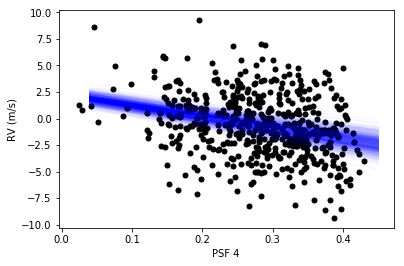

In [191]:
correlate4 = correlate(psf4_hires, rvs_hires, errvels_hires)
x = np.linspace(0.04, 0.45, 50)

fig, ax = plt.subplots()
ax.scatter(psf4_hires, rvs_hires, c='black', marker='o')
for i in np.arange(1000):
    b = np.random.normal(correlate4[0], correlate4[2])
    m = np.random.normal(correlate4[1], correlate4[3])
    ax.plot(x, m*x + b, alpha=0.01, c='blue')
    
ax.set_xlabel('PSF 4')
ax.set_ylabel('RV (m/s)')
fig.savefig('special_systems/69830/psf4_rvs_hires.png', dpi=200)

In [117]:
data = data_all.query('name == "95735" and cts > 3000').reset_index(drop=True)
data_hires = data.query('tel == "j"')# and svalue < 0.175 and svalue > 0.16').reset_index() # svalue for individual file
data_apf   = data.query('tel == "apf"').reset_index()
post = radvel.posterior.load('special_systems/95735/post_final.pkl')

psf1_hires  = np.array(data_hires.psf1)
psf2_hires  = np.array(data_hires.psf2)
psf3_hires  = np.array(data_hires.psf3)
psf4_hires  = np.array(data_hires.psf4)
psf5_hires  = np.array(data_hires.psf5)
psf6_hires  = np.array(data_hires.psf6)
psf7_hires  = np.array(data_hires.psf7)
psf8_hires  = np.array(data_hires.psf8)
psf9_hires  = np.array(data_hires.psf9)
psf10_hires  = np.array(data_hires.psf10)
psf11_hires  = np.array(data_hires.psf11)

psf1_apf  = np.array(data_apf.psf1)
psf2_apf  = np.array(data_apf.psf2)
psf3_apf  = np.array(data_apf.psf3)
psf4_apf  = np.array(data_apf.psf4)
psf5_apf  = np.array(data_apf.psf5)
psf6_apf  = np.array(data_apf.psf6)
psf7_apf  = np.array(data_apf.psf7)
psf8_apf  = np.array(data_apf.psf8)
psf9_apf  = np.array(data_apf.psf9)
psf10_apf  = np.array(data_apf.psf10)
psf11_apf  = np.array(data_apf.psf11)

rvs_hires   = np.array(data_hires.mnvel)
errvels_hires = np.sqrt((np.array(data_hires.errvel))**2 + \
                           post.params['jit_j'].value**2)
rvs_apf     = np.array(data_apf.mnvel)
bcs_hires   = np.array(data_hires.bc)
bcs_apf     = np.array(data_apf.bc)
svals_hires = np.array(data_hires.SVAL) # svalue for individual set
svals_apf   = np.array(data_apf.SVAL)
chis_hires  = np.array(data_hires.mdchi)
chis_apf    = np.array(data_apf.mdchi)

orbel1 = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]
orbel2 = [post.params['per2'].value,
         post.params['tp2'].value,
         post.params['e2'].value,
         post.params['w2'].value,
         post.params['k2'].value]

mod1_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel1)
mod1_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel1)
mod2_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel2)
mod2_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel2)
rvs_hires -= mod1_hires + mod2_hires
rvs_apf   -= mod1_apf + mod2_apf

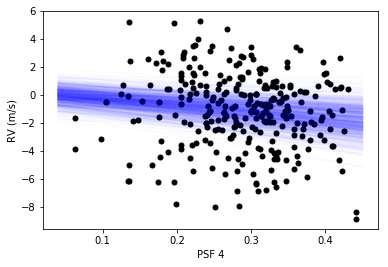

In [116]:
correlate4 = correlate(psf4_hires, rvs_hires, errvels_hires)
x = np.linspace(0.04, 0.45, 50)

fig, ax = plt.subplots()
ax.scatter(psf4_hires, rvs_hires, c='black', marker='o')
for i in np.arange(1000):
    b = np.random.normal(correlate4[0], correlate4[2])
    m = np.random.normal(correlate4[1], correlate4[3])
    ax.plot(x, m*x + b, alpha=0.01, c='blue')
    
ax.set_xlabel('PSF 4')
ax.set_ylabel('RV (m/s)')
fig.savefig('special_systems/95735/psf4_rvs_hires.png', dpi=200)

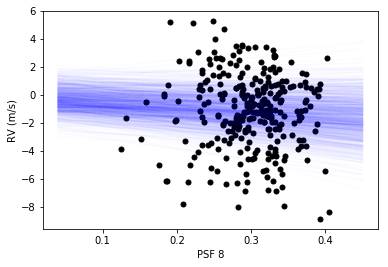

In [119]:
correlate8 = correlate(psf8_hires, rvs_hires, errvels_hires)
x = np.linspace(0.04, 0.45, 50)

fig, ax = plt.subplots()
ax.scatter(psf8_hires, rvs_hires, c='black', marker='o')
for i in np.arange(1000):
    b = np.random.normal(correlate8[0], correlate8[2])
    m = np.random.normal(correlate8[1], correlate8[3])
    ax.plot(x, m*x + b, alpha=0.01, c='blue')
    
ax.set_xlabel('PSF 8')
ax.set_ylabel('RV (m/s)')
fig.savefig('special_systems/95735/psf8_rvs_hires.png', dpi=200)

In [120]:
data = data_all.query('name == "177830" and cts > 3000').reset_index(drop=True)
data_hires = data.query('tel == "j"')# and svalue < 0.175 and svalue > 0.16').reset_index() # svalue for individual file
data_apf   = data.query('tel == "apf"').reset_index()
post = radvel.posterior.load('special_systems/177830/post_final.pkl')

times       = np.array(data_hires.jd)
psf1_hires  = np.array(data_hires.psf1)
psf2_hires  = np.array(data_hires.psf2)
psf3_hires  = np.array(data_hires.psf3)
psf4_hires  = np.array(data_hires.psf4)
psf5_hires  = np.array(data_hires.psf5)
psf6_hires  = np.array(data_hires.psf6)
psf7_hires  = np.array(data_hires.psf7)
psf8_hires  = np.array(data_hires.psf8)
psf9_hires  = np.array(data_hires.psf9)
psf10_hires = np.array(data_hires.psf10)
psf11_hires = np.array(data_hires.psf11)
psf12_hires = np.array(data_hires.psf12)

psfs = [psf1_hires, psf2_hires, psf3_hires,
        psf4_hires, psf5_hires, psf6_hires,
        psf7_hires, psf8_hires, psf9_hires,
        psf10_hires, psf11_hires, psf12_hires]

times_apf = np.array(data_apf.jd)
psf1_apf  = np.array(data_apf.psf1)
psf2_apf  = np.array(data_apf.psf2)
psf3_apf  = np.array(data_apf.psf3)
psf4_apf  = np.array(data_apf.psf4)
psf5_apf  = np.array(data_apf.psf5)
psf6_apf  = np.array(data_apf.psf6)
psf7_apf  = np.array(data_apf.psf7)
psf8_apf  = np.array(data_apf.psf8)
psf9_apf  = np.array(data_apf.psf9)
psf10_apf = np.array(data_apf.psf10)
psf11_apf = np.array(data_apf.psf11)
psf12_apf = np.array(data_apf.psf12)

psfs_apf = [psf1_apf, psf2_apf, psf3_apf,
            psf4_apf, psf5_apf, psf6_apf,
            psf7_apf, psf8_apf, psf9_apf,
            psf10_apf, psf11_apf, psf12_apf]

rvs_hires   = np.array(data_hires.mnvel)
errvels_hires = np.sqrt((np.array(data_hires.errvel))**2 + \
                           post.params['jit_j'].value**2)
rvs_apf     = np.array(data_apf.mnvel)
bcs_hires   = np.array(data_hires.bc)
bcs_apf     = np.array(data_apf.bc)
svals_hires = np.array(data_hires.SVAL) # svalue for individual set
svals_apf   = np.array(data_apf.SVAL)
chis_hires  = np.array(data_hires.mdchi)
chis_apf    = np.array(data_apf.mdchi)

orbel1 = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]

mod1_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel1)
mod1_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel1)
#mod2_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel2)
#mod2_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel2)
rvs_hires -= mod1_hires # + mod2_hires
rvs_apf   -= mod1_apf # + mod2_apf

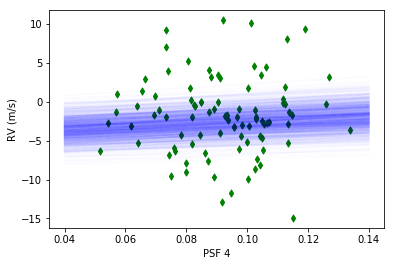

In [123]:
correlate4 = correlate(psf4_hires, rvs_hires, errvels_hires)
x = np.linspace(0.04, 0.14, 50)

fig, ax = plt.subplots()
ax.scatter(psf4_apf, rvs_apf, c='green', marker='d')
for i in np.arange(1000):
    b = np.random.normal(correlate4[0], correlate4[2])
    m = np.random.normal(correlate4[1], correlate4[3])
    ax.plot(x, m*x + b, alpha=0.01, c='blue')
    
ax.set_xlabel('PSF 4')
ax.set_ylabel('RV (m/s)')
fig.savefig('special_systems/177830/psf4_rvs_apf.png', dpi=200)